In [ ]:
import sys
sys.path.append("../")

from torch import nn
from data_utils import load_synsigns, load_GTSRB
from models import DomainAdaptationNetwork, get_simple_classifier, ProjectorNetwork

import torch
from torch.nn import functional as F
import numpy as np
from train import train_domain_adaptation
from utils import test_network, plot_tsne

In [2]:
torch.manual_seed(1)
import numpy as np
np.random.seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_space_dim, conv_feat_size, nb_channels=3):
        super(Decoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.conv_feat_size = conv_feat_size

        self.deco_dense = nn.Sequential(
            nn.Linear(in_features=latent_space_dim, out_features=1024),
            nn.ReLU(True),
            nn.Linear(in_features=1024, out_features=np.prod(self.conv_feat_size)),
            nn.ReLU(True),
        )

        self.deco_fetures = nn.Sequential(
            nn.Conv2d(in_channels=self.conv_feat_size[0], out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=32, out_channels=nb_channels, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

    def forward(self, z_share, z_spe):
        z = torch.cat([z_share, z_spe], 1)
        feat_encode = self.deco_dense(z)
        feat_encode = feat_encode.view(-1, *self.conv_feat_size)
        y = self.deco_fetures(feat_encode)

        return y


class Encoder(nn.Module):
    def __init__(self, latent_space_dim, img_size, nb_channels=3):
        super(Encoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.nb_channels = nb_channels

        self.conv_feat = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.InstanceNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.InstanceNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.InstanceNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.InstanceNorm2d(128),
        )

        self.conv_feat_size = self.conv_feat(torch.zeros(1, *img_size)).shape[1:]
        self.dense_feature_size = np.prod(self.conv_feat_size)

        self.dense_feat = nn.Linear(in_features=self.dense_feature_size, out_features=1024)
        self.task_feat = nn.Linear(in_features=1024, out_features=latent_space_dim)
        self.source_feat = nn.Linear(in_features=1024, out_features=latent_space_dim)
        self.target_feat = nn.Linear(in_features=1024, out_features=latent_space_dim)

    def forward(self, input_data, mode='all'):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = F.relu(self.dense_feat(feat))
        if mode == 'task':
            z_task = F.relu(self.task_feat(feat))
            return z_task
        
        elif mode == 'source':
            z_source = F.relu(self.source_feat(feat))
            return z_source
        
        elif mode == 'target':
            z_target = F.relu(self.target_feat(feat))
            return z_target
        
        else:
            z_task = F.relu(self.task_feat(feat))
            z_source = F.relu(self.source_feat(feat))
            z_target = F.relu(self.target_feat(feat))
            return z_task, z_source, z_target  

In [4]:
def get_simple_classifier(latent_space_dim=1024):
    return nn.Sequential(nn.Dropout2d(),
                         nn.Linear(in_features=latent_space_dim, out_features=43),
                         nn.LogSoftmax(dim=1))

In [5]:
target_loader = load_GTSRB(img_size=64, batch_size=128, shuffle=True, num_workers=4)
source_loader = load_synsigns(img_size=64, batch_size=128, shuffle=True, num_workers=4)

learning_rate = 5e-4
#epochs=10
epochs=30

encoder = Encoder(latent_space_dim=75, img_size=(3,64,64), nb_channels=3)
conv_feat_size = encoder.conv_feat_size
decoder_source = Decoder(latent_space_dim=150, conv_feat_size=conv_feat_size, nb_channels=3)
decoder_target = Decoder(latent_space_dim=150, conv_feat_size=conv_feat_size, nb_channels=3)
classifier = get_simple_classifier(latent_space_dim=75)
model = DomainAdaptationNetwork(encoder, decoder_source, decoder_target, classifier).cuda()
random_projector = ProjectorNetwork(latent_dim=75).cuda()
betas = np.ones(30) * 10
betas[:10] = np.linspace(0, 10, 10)
#betas = np.linspace(0, 5, 30)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.001)

train_domain_adaptation(model, optimizer, random_projector, source_loader, target_loader, betas=betas,
                                            epochs=epochs, alpha=1, gamma=0.5, delta=0.5, show_images=False)

epoch:0 current target accuracy:46.62%:   3%|▎         | 1/30 [01:41<48:56, 101.26s/it]

epoch [1/30], loss:0.9654
accuracy source: 85.21%
accuracy target: 46.72%


epoch:1 current target accuracy:84.53%:   7%|▋         | 2/30 [03:22<47:18, 101.36s/it]

epoch [2/30], loss:0.7472
accuracy source: 98.71%
accuracy target: 84.72%


epoch:2 current target accuracy:92.34%:  10%|█         | 3/30 [05:04<45:40, 101.48s/it]

epoch [3/30], loss:0.6136
accuracy source: 99.51%
accuracy target: 92.54%


epoch:3 current target accuracy:94.63%:  13%|█▎        | 4/30 [06:46<44:04, 101.71s/it]

epoch [4/30], loss:0.5687
accuracy source: 99.52%
accuracy target: 94.84%


epoch:4 current target accuracy:95.07%:  17%|█▋        | 5/30 [08:28<42:26, 101.84s/it]

epoch [5/30], loss:0.5651
accuracy source: 99.49%
accuracy target: 95.28%


epoch:5 current target accuracy:95.35%:  20%|██        | 6/30 [10:10<40:46, 101.93s/it]

epoch [6/30], loss:0.5459
accuracy source: 99.6%
accuracy target: 95.56%


epoch:6 current target accuracy:94.97%:  23%|██▎       | 7/30 [11:52<39:06, 102.01s/it]

epoch [7/30], loss:0.5294
accuracy source: 99.64%
accuracy target: 95.18%


epoch:7 current target accuracy:95.42%:  27%|██▋       | 8/30 [13:34<37:25, 102.05s/it]

epoch [8/30], loss:0.5290
accuracy source: 99.62%
accuracy target: 95.63%


epoch:8 current target accuracy:96.03%:  30%|███       | 9/30 [15:16<35:43, 102.06s/it]

epoch [9/30], loss:0.5182
accuracy source: 99.69%
accuracy target: 96.24%


epoch:9 current target accuracy:95.23%:  33%|███▎      | 10/30 [16:59<34:01, 102.08s/it]

epoch [10/30], loss:0.5273
accuracy source: 99.63%
accuracy target: 95.44%


epoch:10 current target accuracy:95.96%:  37%|███▋      | 11/30 [18:41<32:19, 102.09s/it]

epoch [11/30], loss:0.5112
accuracy source: 99.69%
accuracy target: 96.17%


epoch:11 current target accuracy:95.92%:  40%|████      | 12/30 [20:23<30:37, 102.07s/it]

epoch [12/30], loss:0.5178
accuracy source: 99.61%
accuracy target: 96.13%


epoch:12 current target accuracy:96.12%:  43%|████▎     | 13/30 [22:05<28:54, 102.03s/it]

epoch [13/30], loss:0.4995
accuracy source: 99.67%
accuracy target: 96.33%


epoch:13 current target accuracy:95.21%:  47%|████▋     | 14/30 [23:47<27:12, 102.05s/it]

epoch [14/30], loss:0.5051
accuracy source: 99.67%
accuracy target: 95.42%


epoch:14 current target accuracy:95.03%:  50%|█████     | 15/30 [25:29<25:31, 102.07s/it]

epoch [15/30], loss:0.4840
accuracy source: 99.71%
accuracy target: 95.24%


epoch:15 current target accuracy:95.81%:  53%|█████▎    | 16/30 [27:11<23:49, 102.07s/it]

epoch [16/30], loss:0.4831
accuracy source: 99.71%
accuracy target: 96.03%


epoch:16 current target accuracy:96.08%:  57%|█████▋    | 17/30 [28:53<22:06, 102.06s/it]

epoch [17/30], loss:0.5075
accuracy source: 99.63%
accuracy target: 96.3%


epoch:17 current target accuracy:96.66%:  60%|██████    | 18/30 [30:35<20:24, 102.06s/it]

epoch [18/30], loss:0.4930
accuracy source: 99.7%
accuracy target: 96.88%


epoch:18 current target accuracy:95.15%:  63%|██████▎   | 19/30 [32:17<18:42, 102.06s/it]

epoch [19/30], loss:0.4857
accuracy source: 99.72%
accuracy target: 95.36%


epoch:19 current target accuracy:94.96%:  67%|██████▋   | 20/30 [33:59<17:00, 102.07s/it]

epoch [20/30], loss:0.4774
accuracy source: 99.74%
accuracy target: 95.17%


epoch:20 current target accuracy:96.03%:  70%|███████   | 21/30 [35:41<15:18, 102.04s/it]

epoch [21/30], loss:0.4942
accuracy source: 99.66%
accuracy target: 96.24%


epoch:21 current target accuracy:97.04%:  73%|███████▎  | 22/30 [37:23<13:36, 102.06s/it]

epoch [22/30], loss:0.5094
accuracy source: 99.52%
accuracy target: 97.25%


epoch:22 current target accuracy:96.9%:  77%|███████▋  | 23/30 [39:05<11:54, 102.03s/it] 

epoch [23/30], loss:0.4953
accuracy source: 99.62%
accuracy target: 97.11%


epoch:23 current target accuracy:96.51%:  80%|████████  | 24/30 [40:47<10:12, 102.02s/it]

epoch [24/30], loss:0.4908
accuracy source: 99.68%
accuracy target: 96.72%


epoch:24 current target accuracy:96.81%:  83%|████████▎ | 25/30 [42:29<08:30, 102.00s/it]

epoch [25/30], loss:0.4830
accuracy source: 99.67%
accuracy target: 97.02%


epoch:25 current target accuracy:97.23%:  87%|████████▋ | 26/30 [44:11<06:48, 102.01s/it]

epoch [26/30], loss:0.4640
accuracy source: 99.77%
accuracy target: 97.45%


epoch:26 current target accuracy:97.08%:  90%|█████████ | 27/30 [45:53<05:06, 102.00s/it]

epoch [27/30], loss:0.4616
accuracy source: 99.78%
accuracy target: 97.29%


epoch:27 current target accuracy:97.02%:  93%|█████████▎| 28/30 [47:35<03:24, 102.01s/it]

epoch [28/30], loss:0.4670
accuracy source: 99.77%
accuracy target: 97.24%


epoch:28 current target accuracy:97.09%:  97%|█████████▋| 29/30 [49:17<01:42, 102.00s/it]

epoch [29/30], loss:0.4701
accuracy source: 99.76%
accuracy target: 97.3%


epoch:29 current target accuracy:97.53%: 100%|██████████| 30/30 [50:59<00:00, 101.99s/it]

epoch [30/30], loss:0.4872
accuracy source: 99.73%
accuracy target: 97.75%


In [6]:
model.eval()
test_network(model, target_loader)

0.9804126603585911

In [7]:
betas = np.ones(30) * 10
#betas = np.linspace(0, 5, 30)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=0.001)

train_domain_adaptation(model, optimizer, random_projector, source_loader, target_loader, betas=betas,
                                            epochs=epochs, alpha=1, gamma=0.5, delta=0.5, show_images=False)

epoch:0 current target accuracy:97.78%:   3%|▎         | 1/30 [01:42<49:20, 102.09s/it]

epoch [1/30], loss:0.4285
accuracy source: 99.93%
accuracy target: 98.0%


epoch:1 current target accuracy:97.78%:   7%|▋         | 2/30 [03:24<47:42, 102.24s/it]

epoch [2/30], loss:0.4206
accuracy source: 99.94%
accuracy target: 97.99%


epoch:2 current target accuracy:97.83%:  10%|█         | 3/30 [05:08<46:26, 103.21s/it]

epoch [3/30], loss:0.4175
accuracy source: 99.96%
accuracy target: 98.04%


epoch:3 current target accuracy:97.8%:  13%|█▎        | 4/30 [06:54<45:12, 104.34s/it] 

epoch [4/30], loss:0.4149
accuracy source: 99.95%
accuracy target: 98.02%


epoch:4 current target accuracy:97.82%:  17%|█▋        | 5/30 [08:41<43:46, 105.05s/it]

epoch [5/30], loss:0.4123
accuracy source: 99.95%
accuracy target: 98.04%


epoch:5 current target accuracy:97.83%:  20%|██        | 6/30 [10:24<41:50, 104.59s/it]

epoch [6/30], loss:0.4120
accuracy source: 99.96%
accuracy target: 98.04%


epoch:6 current target accuracy:97.81%:  23%|██▎       | 7/30 [12:07<39:47, 103.81s/it]

epoch [7/30], loss:0.4112
accuracy source: 99.97%
accuracy target: 98.03%


epoch:7 current target accuracy:97.8%:  27%|██▋       | 8/30 [13:49<37:52, 103.30s/it] 

epoch [8/30], loss:0.4110
accuracy source: 99.97%
accuracy target: 98.02%


epoch:8 current target accuracy:97.81%:  30%|███       | 9/30 [15:31<36:02, 102.99s/it]

epoch [9/30], loss:0.4117
accuracy source: 99.97%
accuracy target: 98.03%


epoch:9 current target accuracy:97.8%:  33%|███▎      | 10/30 [17:13<34:15, 102.76s/it]

epoch [10/30], loss:0.4107
accuracy source: 99.97%
accuracy target: 98.02%


epoch:10 current target accuracy:97.8%:  37%|███▋      | 11/30 [18:56<32:29, 102.59s/it] 

epoch [11/30], loss:0.4091
accuracy source: 99.96%
accuracy target: 98.02%


epoch:11 current target accuracy:97.81%:  40%|████      | 12/30 [20:38<30:44, 102.46s/it]

epoch [12/30], loss:0.4094
accuracy source: 99.97%
accuracy target: 98.02%


epoch:12 current target accuracy:97.8%:  43%|████▎     | 13/30 [22:20<29:00, 102.40s/it] 

epoch [13/30], loss:0.4084
accuracy source: 99.97%
accuracy target: 98.02%


epoch:13 current target accuracy:97.8%:  47%|████▋     | 14/30 [24:02<27:17, 102.34s/it] 

epoch [14/30], loss:0.4090
accuracy source: 99.97%
accuracy target: 98.02%


epoch:14 current target accuracy:97.81%:  50%|█████     | 15/30 [25:44<25:34, 102.30s/it]

epoch [15/30], loss:0.4070
accuracy source: 99.97%
accuracy target: 98.02%


epoch:15 current target accuracy:97.8%:  53%|█████▎    | 16/30 [27:27<23:51, 102.27s/it] 

epoch [16/30], loss:0.4059
accuracy source: 99.97%
accuracy target: 98.01%


epoch:16 current target accuracy:97.8%:  57%|█████▋    | 17/30 [29:09<22:09, 102.24s/it] 

epoch [17/30], loss:0.4075
accuracy source: 99.97%
accuracy target: 98.02%


epoch:17 current target accuracy:97.8%:  60%|██████    | 18/30 [30:51<20:26, 102.24s/it] 

epoch [18/30], loss:0.4080
accuracy source: 99.98%
accuracy target: 98.02%


epoch:18 current target accuracy:97.81%:  63%|██████▎   | 19/30 [32:33<18:44, 102.25s/it]

epoch [19/30], loss:0.4054
accuracy source: 99.98%
accuracy target: 98.03%


epoch:19 current target accuracy:97.81%:  67%|██████▋   | 20/30 [34:15<17:02, 102.23s/it]

epoch [20/30], loss:0.4057
accuracy source: 99.97%
accuracy target: 98.02%


epoch:20 current target accuracy:97.8%:  70%|███████   | 21/30 [35:58<15:20, 102.23s/it] 

epoch [21/30], loss:0.4054
accuracy source: 99.97%
accuracy target: 98.02%


epoch:21 current target accuracy:97.81%:  73%|███████▎  | 22/30 [37:40<13:37, 102.22s/it]

epoch [22/30], loss:0.4064
accuracy source: 99.96%
accuracy target: 98.03%


epoch:22 current target accuracy:97.81%:  77%|███████▋  | 23/30 [39:22<11:55, 102.19s/it]

epoch [23/30], loss:0.4045
accuracy source: 99.97%
accuracy target: 98.03%


epoch:23 current target accuracy:97.81%:  80%|████████  | 24/30 [41:04<10:13, 102.21s/it]

epoch [24/30], loss:0.4057
accuracy source: 99.98%
accuracy target: 98.03%


epoch:24 current target accuracy:97.81%:  83%|████████▎ | 25/30 [42:46<08:30, 102.19s/it]

epoch [25/30], loss:0.4032
accuracy source: 99.98%
accuracy target: 98.03%


epoch:25 current target accuracy:97.81%:  87%|████████▋ | 26/30 [44:29<06:48, 102.18s/it]

epoch [26/30], loss:0.4039
accuracy source: 99.97%
accuracy target: 98.03%


epoch:26 current target accuracy:97.81%:  90%|█████████ | 27/30 [46:11<05:06, 102.18s/it]

epoch [27/30], loss:0.4042
accuracy source: 99.97%
accuracy target: 98.03%


epoch:27 current target accuracy:97.81%:  93%|█████████▎| 28/30 [47:53<03:24, 102.17s/it]

epoch [28/30], loss:0.4033
accuracy source: 99.98%
accuracy target: 98.03%


epoch:28 current target accuracy:97.81%:  97%|█████████▋| 29/30 [49:35<01:42, 102.16s/it]

epoch [29/30], loss:0.4033
accuracy source: 99.98%
accuracy target: 98.03%


epoch:29 current target accuracy:97.81%: 100%|██████████| 30/30 [51:17<00:00, 102.59s/it]

epoch [30/30], loss:0.4023
accuracy source: 99.98%
accuracy target: 98.03%


In [8]:
model.eval()
test_network(model, target_loader)

0.9802596342676426

In [11]:
import matplotlib.pyplot as plt
def plot_target_cross_domain_swapping(model, source_train_loader, target_train_loader):
    X, _ = next(iter(target_train_loader))
    y, _, (z_share, z_spe),  _ = model(X.cuda(), mode='all_target')
    X2, _ = next(iter(source_train_loader))
    _, _, (z_share, _),  _ = model(X2.cuda(), mode='all_target')
    #blank
    plt.subplot(1,6,1)
    plt.imshow(torch.ones((32,32,3)))
    plt.axis('off')
    plt.tight_layout()
    #styles
    for i in range(5):
        plt.subplot(1,6,i+2)
        plt.imshow(X[i].cpu().detach().permute(1, 2, 0))
        plt.axis('off')
        plt.tight_layout()

    for j in range(10, 20):
        plt.figure()
        plt.subplot(1,6,1)
        plt.imshow(X2[j].cpu().detach().permute(1, 2, 0))
        plt.axis('off')
        plt.tight_layout()

        z_x = torch.zeros_like(z_share)
        z_x[:] = z_share[j]
        y2  = model.decoder_target(z_x, z_spe)
        for i in range(5):
            plt.subplot(1,6,i+2)
            plt.imshow(y2[i].cpu().detach().permute(1, 2, 0))
            plt.axis('off')
            plt.tight_layout()

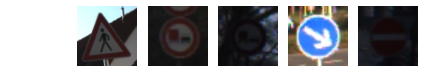

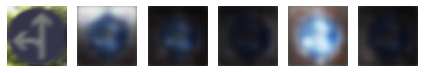

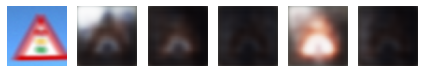

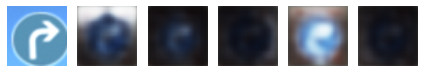

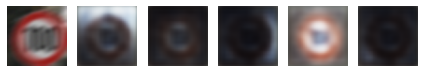

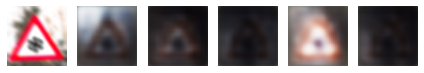

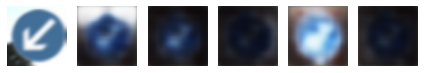

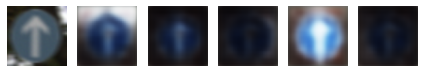

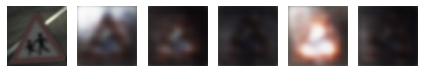

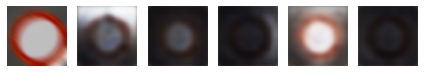

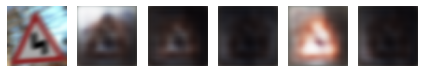

In [12]:
plot_target_cross_domain_swapping(model, source_loader, target_loader)
#plot_tsne(model, source_train_loader, target_train_loader, 128, 75)